# Titanic: Machine Learning from Disaster

***By Joe Corliss***

## Table of Contents

* [1 Introduction](#1)
* [2 Getting Started](#2)
    * [2.1 Imports](#2.1)
    * [2.2 Read In the Data](#2.2)
* [3 Pre-processing](#3)
    * [3.1 Feature Engineering](#3.1)
    * [3.2 One-Hot Encoding](#3.2)
    * [3.3 Imputation with Mean Substitution](#3.3)
    * [3.4 Standardization](#3.4)
    * [3.5 Recursive Feature Elimination](#3.5)
* [4 Predictive Modeling](#4)
    * [4.1 Random Forest](#4.1)
    * [4.2 Gradient Boosting](#4.2)
    * [4.3 Logistic Regression](#4.3)
    * [4.4 Gaussian Naive Bayes](#4.4)
    * [4.5 Support Vector Classifier](#4.5)
    * [4.6 k-Nearest Neighbors](#4.6)
* [5 Conclusion](#5)
    * [5.1 Results Summary](#5.1)
    * [5.2 Test Set Predictions](#5.2)

# 1 Introduction
<a id='1'></a>

[Kaggle competition](https://www.kaggle.com/c/titanic) - The competition page on Kaggle

[Kaggle notebook](https://www.kaggle.com/pileatedperch/titanic-predicting-survival) - This notebook hosted on Kaggle

[GitHub repository](https://github.com/jgcorliss/titanic-competition) - GitHub repo for this project

"The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

Your score is the percentage of passengers you correctly predict. This is known simply as 'accuracy.'"

# 2 Getting Started
<a id='2'></a>

## 2.1 Imports
<a id='2.1'></a>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

## 2.2 Read In the Data
<a id='2.2'></a>

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.shape

(891, 12)

In [4]:
df_test.shape

(418, 11)

Save the test set passenders IDs for later:

In [5]:
TestPassengerId = df_test.loc[:,'PassengerId']

Concatenate the train and test sets together:

In [6]:
df = df_train.append(df_test, ignore_index=True)

Basic metadata:

In [7]:
df.shape

(1309, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Find incomplete columns:

In [9]:
def incomplete_cols(df):
    """
    Returns a list of incomplete columns in df and their fraction of non-null values.
    
    Input: pandas DataFrame
    Returns: pandas Series
    """
    cmp = df.notnull().mean().sort_values()
    return cmp.loc[cmp<1]

In [10]:
incomplete_cols(df)

Cabin       0.225363
Survived    0.680672
Age         0.799083
Embarked    0.998472
Fare        0.999236
dtype: float64

In [11]:
df.sample(5) # Display some random rows

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
651,18.0,NaN,S,23.0000,"Doling, Miss. Elsie",1,652,2,female,0,1.0,231919
752,33.0,NaN,S,9.5000,"Vande Velde, Mr. Johannes Joseph",0,753,3,male,0,0.0,345780
1211,26.0,NaN,S,7.7750,"Andersson, Mr. Johan Samuel",0,1212,3,male,0,NaN,347075
975,NaN,NaN,Q,10.7083,"Lamb, Mr. John Joseph",0,976,2,male,0,NaN,240261
142,24.0,NaN,S,15.8500,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda Dolck)",0,143,3,female,1,1.0,STON/O2. 3101279


# 3 Pre-processing
<a id='3'></a>

## 3.1 Feature Engineering
<a id='3.1'></a>

### Age

In [12]:
df['Age'].notnull().mean()

0.799083269671505

In [13]:
df['Age_NA'] = df['Age'].isnull()

Text(0.5,1,'Histogram of Passenger Age')

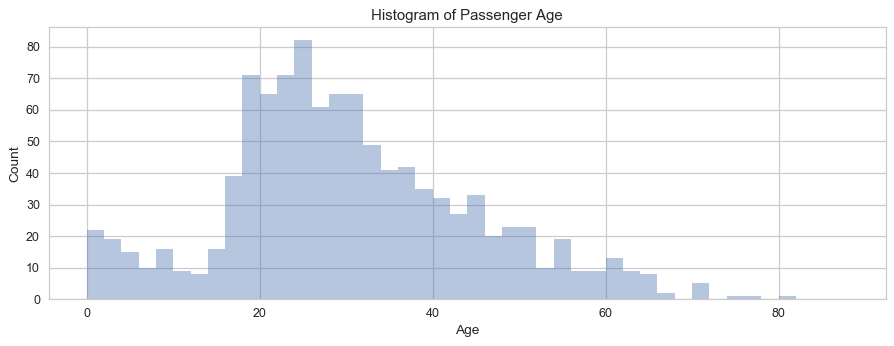

In [14]:
plt.figure(figsize=(12,4), dpi=90)
sns.distplot(df.loc[df['Age'].notnull(), 'Age'], bins=range(0, 90, 2), kde=False)
plt.ylabel('Count')
plt.title('Histogram of Passenger Age')

### Cabin

In [15]:
df['Cabin'].notnull().mean()

0.22536287242169595

Extract the cabin letter (A, B, C, etc), or NA if the cabin data is missing.

In [16]:
def find_cabin(s):
    try:
        return s[0]
    except:
        return 'NA'

In [17]:
df.loc[:,'Cabin'] = df['Cabin'].apply(find_cabin)

In [18]:
df['Cabin'].value_counts()

NA    1014
C       94
B       65
D       46
E       41
A       22
F       21
G        5
T        1
Name: Cabin, dtype: int64

### Embarked

In [19]:
df['Embarked'].value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: Embarked, dtype: int64

Only 2 passengers do not have a port of embarkation.

Text(0.5,1,'Passenger Ports of Embarkation')

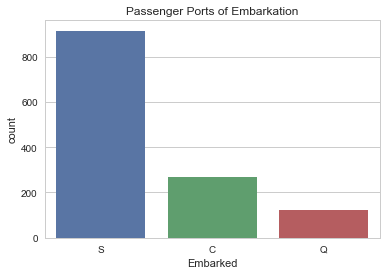

In [20]:
sns.countplot(x='Embarked', data=df)
plt.title('Passenger Ports of Embarkation')

### Fare

In [21]:
df['Fare'].isnull().sum()

1

Only one fare is missing. Who is that?

In [22]:
df.loc[df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_NA
1043,60.5,NA,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,False


Not sure why his fare is missing. Let's plot the fares:

Text(0.5,1,'Histogram of Passenger Fares')

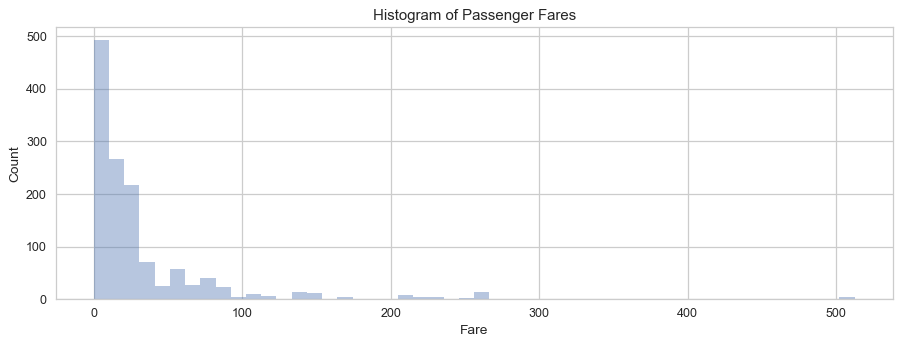

In [23]:
plt.figure(figsize=(12,4), dpi=90)
sns.distplot(df.loc[df['Fare'].notnull(), 'Fare'], kde=False)
plt.ylabel('Count')
plt.title('Histogram of Passenger Fares')

In [24]:
df['Fare'].skew()

4.367709134122922

The fares are right-skewed.

### Name

In [25]:
df['Name'].notnull().mean()

1.0

In [26]:
df['Name'].sample(5)

1002                 Shine, Miss. Ellen Natalia
1083          van Billiard, Master. Walter John
930                               Hee, Mr. Ling
1259    Gibson, Mrs. Leonard (Pauline C Boeson)
1067                       Sincock, Miss. Maude
Name: Name, dtype: object

Let's extract everyone's titles.

In [27]:
df['Title'] = df['Name'].apply(lambda s: s.split(', ')[1].split(' ')[0])

In [28]:
df['Title'].nunique()

18

Did it work?

In [29]:
df[['Name', 'Title']].sample(10)

,Name,Title
1210,"Jefferys, Mr. Ernest Wilfred",Mr.
377,"Widener, Mr. Harry Elkins",Mr.
288,"Hosono, Mr. Masabumi",Mr.
1227,"de Brito, Mr. Jose Joaquim",Mr.
921,"Louch, Mr. Charles Alexander",Mr.
490,"Hagland, Mr. Konrad Mathias Reiersen",Mr.
1209,"Jonsson, Mr. Nils Hilding",Mr.
139,"Giglio, Mr. Victor",Mr.
859,"Razi, Mr. Raihed",Mr.
723,"Hodges, Mr. Henry Price",Mr.


Seems good. Title value counts:

In [30]:
df['Title'].value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Major.         2
Ms.            2
Mlle.          2
Lady.          1
the            1
Dona.          1
Sir.           1
Mme.           1
Capt.          1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64

The only odd-looking value is "the". Let's investigate.

In [31]:
df.loc[df['Title']=='the']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_NA,Title
759,33.0,B,S,86.5,"Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)",0,760,1,female,0,1.0,110152,False,the


Her title is actually "Countess."

There doesn't seem to be any new information in `Title`. We already know the passenger age, sex, marital status (`SibSp`), and economic class (`Pclass`). Furthermore, many of the titles have too few data points to be useful. So we're going to drop the `Name` and `Title` columns.

In [32]:
df.drop(labels=['Name','Title'], axis=1, inplace=True)

### Parch

In [33]:
df['Parch'].notnull().mean()

1.0

In [34]:
df['Parch'].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

Text(0.5,1,'Number of Parents/Children')

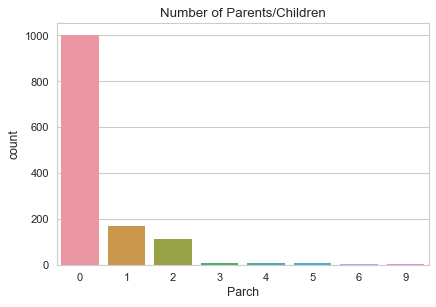

In [35]:
plt.figure(dpi=80)
sns.countplot(x='Parch', data=df)
plt.title('Number of Parents/Children')

### PassengerId

In [36]:
df.shape[0]

1309

In [37]:
df['PassengerId'].nunique()

1309

All passenger IDs are unique. The IDs will (probably) be removed in automatic variable selection.

### Pclass

In [38]:
df['Pclass'].notnull().mean()

1.0

In [39]:
df['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

A majority of the passengers are Lower Class.

Text(0.5,1,'Passenger Ticket Class')

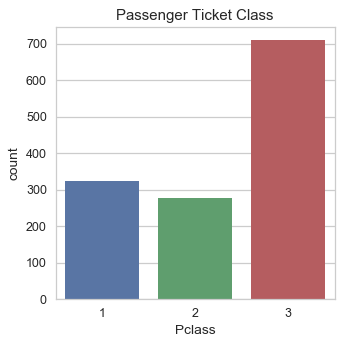

In [40]:
plt.figure(figsize=(4,4), dpi=90)
sns.countplot(x='Pclass', data=df)
plt.title('Passenger Ticket Class')

### Sex

In [41]:
df['Sex'].notnull().mean()

1.0

In [42]:
df['Sex'].value_counts(normalize=True)

male      0.644003
female    0.355997
Name: Sex, dtype: float64

The passengers are 64.4% male.

### SibSp

In [43]:
df['SibSp'].notnull().mean()

1.0

In [44]:
df['SibSp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

Text(0.5,1,'Number of Siblings/Spouses')

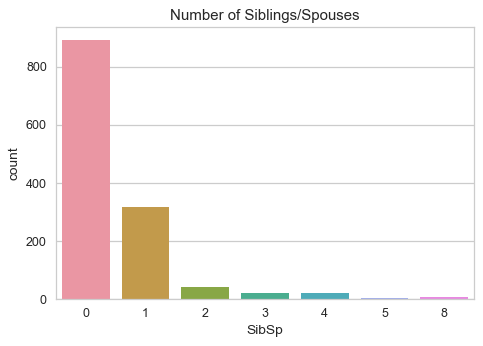

In [45]:
plt.figure(dpi=90)
sns.countplot(x='SibSp', data=df)
plt.title('Number of Siblings/Spouses')

### Survived

This is the target variable.

In [46]:
df.loc[df['Survived'].notnull(), 'Survived'].value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

So there's a 38.4% survival rate in the training set.

### Ticket

In [47]:
df['Ticket'].notnull().mean()

1.0

In [48]:
(df['Ticket'].nunique(), df.shape[0])

(929, 1309)

Apparently there are duplicate tickets...? That's weird.

In [49]:
df['Ticket'].sample(10)

730           24160
793        PC 17600
454        A/5 2817
335          349225
510          382651
150     S.O.P. 1166
823          392096
1010    SC/AH 29037
444           65306
957          330963
Name: Ticket, dtype: object

Maybe the prefix on some of the tickets is important? Let's grab it.

In [50]:
def ticket_prefix(s):
    'Find the content of the ticket before the ticket number'
    temp = s.split(' ')
    if len(temp) > 1:
        return ' '.join(temp[:-1])
    else:
        return 'NONE'

In [51]:
df.loc[:,'Ticket Prefix'] = df['Ticket'].apply(ticket_prefix)

In [52]:
df['Ticket Prefix'].nunique()

51

In [53]:
df['Ticket Prefix'].value_counts()

NONE           961
PC              92
C.A.            46
SOTON/O.Q.      16
W./C.           14
STON/O 2.       14
A/5             12
CA.             12
SC/PARIS        11
CA              10
A/5.            10
F.C.C.           9
C                8
SOTON/OQ         8
S.O.C.           7
S.O./P.P.        7
STON/O2.         7
A/4              6
SC/Paris         5
SC/AH            4
PP               4
A/4.             3
A.5.             3
A./5.            3
SOTON/O2         3
S.C./PARIS       3
F.C.             3
P/PP             2
W.E.P.           2
WE/P             2
SC               2
STON/OQ.         1
A/S              1
A4.              1
SCO/W            1
LP               1
SW/PP            1
Fa               1
SO/C             1
S.P.             1
SC/AH Basle      1
C.A./SOTON       1
S.O.P.           1
SC/A.3           1
S.C./A.4.        1
AQ/3.            1
A. 2.            1
W/C              1
SC/A4            1
S.W./PP          1
AQ/4             1
Name: Ticket Prefix, dtype: int

Some of the prefixes are very similar. Let's assume that the characters `.`, `/`, and whitespace and not significant, and that `SC/PARIS` is the same as `SC/Paris`.

In [54]:
df.loc[:,'Ticket Prefix'] = df['Ticket Prefix'].apply(lambda s: s.replace('.','').replace('/','').replace(' ','').upper())

In [55]:
df['Ticket Prefix'].nunique()

35

In [56]:
df['Ticket Prefix'].value_counts()

NONE         961
PC            92
CA            68
A5            28
SOTONOQ       24
STONO2        21
SCPARIS       19
WC            15
A4            10
FCC            9
C              8
SOC            8
SOPP           7
PP             4
SCAH           4
WEP            4
FC             3
SOTONO2        3
SWPP           2
PPP            2
SCA4           2
SC             2
FA             1
AQ4            1
SCOW           1
SP             1
CASOTON        1
AS             1
STONOQ         1
LP             1
SCA3           1
A2             1
SOP            1
AQ3            1
SCAHBASLE      1
Name: Ticket Prefix, dtype: int64

If there are fewer than 10 occurences of a particular prefix, we'll reclassify it as "other."

In [57]:
vals = df['Ticket Prefix'].value_counts()

def other_prefix(prefix):
    if vals[prefix] < 10:
        return "OTHER"
    else:
        return prefix

In [58]:
df.loc[:,'Ticket Prefix'] = df['Ticket Prefix'].apply(other_prefix)

In [59]:
df['Ticket Prefix'].value_counts()

NONE       961
PC          92
OTHER       71
CA          68
A5          28
SOTONOQ     24
STONO2      21
SCPARIS     19
WC          15
A4          10
Name: Ticket Prefix, dtype: int64

Now let's extract the ticket number. As it turns out, a very small number of tickets have no ticket number, so we'll assign NaN for those tickets.

In [60]:
def ticket_number(s):
    'Find the ticket number on a ticket'
    try:
        return np.int64(s.split(' ')[-1])
    except:
        return np.nan

In [61]:
df['Ticket Number'] = df['Ticket'].apply(ticket_number)

In [62]:
df['Ticket Number'].isnull().sum()

4

There are 4 tickets with no ticket number. Let's look at those:

In [63]:
df.loc[df['Ticket Number'].isnull()]

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_NA,Ticket Prefix,Ticket Number
179,36.0,NA,S,0.0,0,180,3,male,0,0.0,LINE,False,NONE,NaN
271,25.0,NA,S,0.0,0,272,3,male,0,1.0,LINE,False,NONE,NaN
302,19.0,NA,S,0.0,0,303,3,male,0,0.0,LINE,False,NONE,NaN
597,49.0,NA,S,0.0,0,598,3,male,0,0.0,LINE,False,NONE,NaN


Their ticket just says "LINE." What does that mean?

Let's plot the ticket numbers.

Text(0.5,1,'Histogram of Ticket Number')

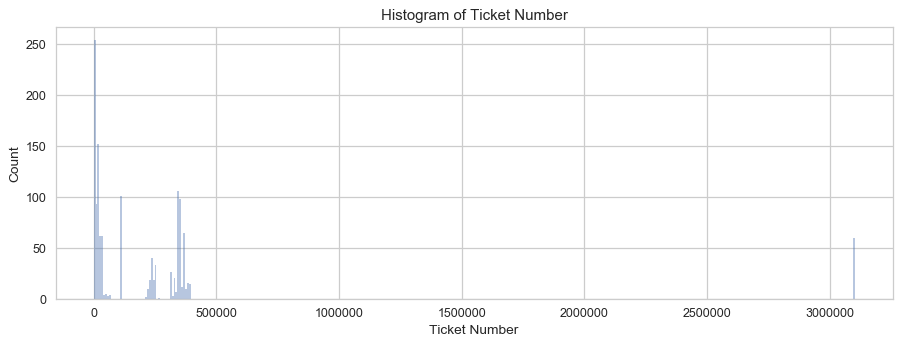

In [64]:
plt.figure(figsize=(12,4), dpi=90)
sns.distplot(df.loc[df['Ticket Number'].notnull(), 'Ticket Number'], bins=400, kde=False)
plt.ylabel('Count')
plt.title('Histogram of Ticket Number')

Text(0.5,1,'Histogram of Ticket Number')

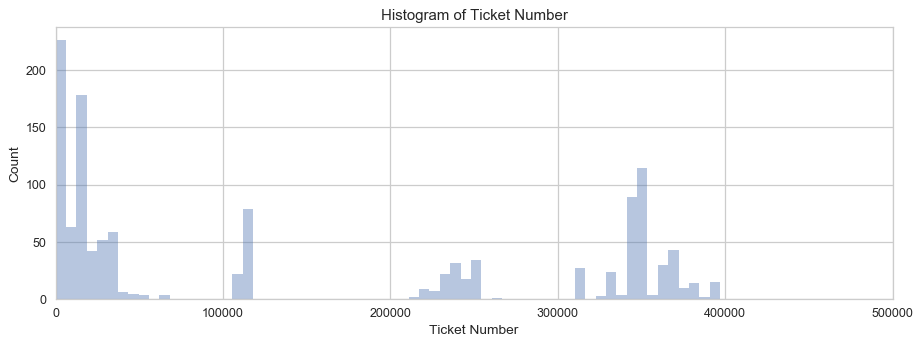

In [65]:
plt.figure(figsize=(12,4), dpi=90)
sns.distplot(df.loc[df['Ticket Number'].notnull(), 'Ticket Number'], bins=500, kde=False)
plt.xlim([0, 500000])
plt.ylabel('Count')
plt.title('Histogram of Ticket Number')

There are 5 "classes" of ticket numbers. Let's convert the ticket numbers into these categorical classes.

In [66]:
def tick_num_class(tick_num):
    if tick_num < 100000:
        return 'A'
    elif tick_num < 200000:
        return 'B'
    elif tick_num < 300000:
        return 'C'
    elif tick_num < 400000:
        return 'D'
    elif tick_num >= 400000:
        return 'E'
    else:
        return 'NA'

In [67]:
df.loc[:,'Ticket Number'] = df['Ticket Number'].apply(tick_num_class)

In [68]:
df['Ticket Number'].value_counts()

A     639
D     380
C     125
B     101
E      60
NA      4
Name: Ticket Number, dtype: int64

In [69]:
df.drop(labels='Ticket', axis=1, inplace=True)

## 3.2 One-Hot Encoding
<a id='3.2'></a>

Convert categorical features to binary features via one-hot encoding.

In [70]:
df.sample(5)

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Age_NA,Ticket Prefix,Ticket Number
658,23.0,NA,S,13.0000,0,659,2,male,0,0.0,False,NONE,A
691,4.0,NA,C,13.4167,1,692,3,female,0,1.0,False,NONE,D
1130,48.0,C,C,106.4250,0,1131,1,female,1,NaN,False,PC,A
317,54.0,NA,S,14.0000,0,318,2,male,0,0.0,False,NONE,A
162,26.0,NA,S,7.7750,0,163,3,male,0,0.0,False,NONE,D


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age              1046 non-null float64
Cabin            1309 non-null object
Embarked         1307 non-null object
Fare             1308 non-null float64
Parch            1309 non-null int64
PassengerId      1309 non-null int64
Pclass           1309 non-null int64
Sex              1309 non-null object
SibSp            1309 non-null int64
Survived         891 non-null float64
Age_NA           1309 non-null bool
Ticket Prefix    1309 non-null object
Ticket Number    1309 non-null object
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 124.1+ KB


Five columns will be one-hot encoded: `Cabin`, `Embarked`, `Sex`, `Ticket Prefix`, and `Ticket Number`. Are any of these columns incomplete?

In [72]:
incomplete_cols(df)

Survived    0.680672
Age         0.799083
Embarked    0.998472
Fare        0.999236
dtype: float64

Only `Embarked` is. But only 2 values were missing in that column, so we won't create columns for NA values.

In [73]:
df.shape

(1309, 13)

In [74]:
df = pd.get_dummies(df, drop_first=True)

In [75]:
df.shape

(1309, 33)

In [76]:
df.sample(5)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Age_NA,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NA,Cabin_T,Embarked_Q,Embarked_S,Sex_male,Ticket Prefix_A5,Ticket Prefix_CA,Ticket Prefix_NONE,Ticket Prefix_OTHER,Ticket Prefix_PC,Ticket Prefix_SCPARIS,Ticket Prefix_SOTONOQ,Ticket Prefix_STONO2,Ticket Prefix_WC,Ticket Number_B,Ticket Number_C,Ticket Number_D,Ticket Number_E,Ticket Number_NA
619,26.0,10.5,0,620,2,0,0.0,False,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
360,40.0,27.9,4,361,3,1,0.0,False,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
53,29.0,26.0,0,54,2,1,1.0,False,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
556,48.0,39.6,0,557,1,1,1.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1094,8.0,26.0,1,1095,2,1,NaN,False,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## 3.3 Imputation with Mean Substitution
<a id='3.3'></a>

In [77]:
X = df.drop(labels='Survived', axis=1)
y = df.loc[:,'Survived']

In [78]:
incomplete_cols(X)

Age     0.799083
Fare    0.999236
dtype: float64

In [79]:
from sklearn.preprocessing import Imputer

In [80]:
imputer = Imputer().fit(X)

In [81]:
X = pd.DataFrame(imputer.transform(X), columns=X.columns)

In [82]:
incomplete_cols(X)

Series([], dtype: float64)

## 3.4 Standardization
<a id='3.4'></a>

Transform all the features to zero mean and unit variance.

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler().fit(X)

In [85]:
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [86]:
X.sample(5)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Age_NA,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NA,Cabin_T,Embarked_Q,Embarked_S,Sex_male,Ticket Prefix_A5,Ticket Prefix_CA,Ticket Prefix_NONE,Ticket Prefix_OTHER,Ticket Prefix_PC,Ticket Prefix_SCPARIS,Ticket Prefix_SOTONOQ,Ticket Prefix_STONO2,Ticket Prefix_WC,Ticket Number_B,Ticket Number_C,Ticket Number_D,Ticket Number_E,Ticket Number_NA
382,0.164530,-0.490544,-0.445000,-0.719814,0.841916,-0.479087,-0.501432,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,0.539377,-0.02765,-0.32204,0.657394,0.743497,-0.147844,-0.234082,-1.661774,-0.23948,-0.274947,-0.121362,-0.136664,7.831560,-0.107666,-0.289153,-0.324922,-0.639564,4.562529,-0.055364
110,1.329283,0.361656,-0.445000,-1.439627,-1.546098,-0.479087,-0.501432,-0.228584,3.595210,-0.190843,-0.179818,-0.127688,-0.061922,-1.853992,-0.02765,-0.32204,0.657394,0.743497,-0.147844,-0.234082,0.601766,-0.23948,-0.274947,-0.121362,-0.136664,-0.127688,-0.107666,3.458381,-0.324922,-0.639564,-0.219177,-0.055364
41,-0.223721,-0.237736,-0.445000,-1.622227,-0.352091,0.481288,-0.501432,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,0.539377,-0.02765,-0.32204,0.657394,-1.344995,-0.147844,-0.234082,0.601766,-0.23948,-0.274947,-0.121362,-0.136664,-0.127688,-0.107666,-0.289153,-0.324922,-0.639564,-0.219177,-0.055364
779,1.018682,3.442480,0.710763,0.330797,-1.546098,-0.479087,-0.501432,4.374753,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,-1.853992,-0.02765,-0.32204,0.657394,-1.344995,-0.147844,-0.234082,0.601766,-0.23948,-0.274947,-0.121362,-0.136664,-0.127688,-0.107666,-0.289153,-0.324922,-0.639564,-0.219177,-0.055364
631,1.639883,-0.507381,-0.445000,-0.060867,0.841916,-0.479087,-0.501432,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,0.539377,-0.02765,-0.32204,0.657394,0.743497,-0.147844,-0.234082,0.601766,-0.23948,-0.274947,-0.121362,-0.136664,-0.127688,-0.107666,-0.289153,-0.324922,1.563565,-0.219177,-0.055364


## 3.5 Recursive Feature Elimination
<a id='3.5'></a>

Train/test split:

In [87]:
X_train = X.loc[y.notnull()]
X_test = X.loc[y.isnull()]
y_train = y[y.notnull()].apply(np.bool)

Recursive feature elimination using a Linear Support Vector Classifier:

In [88]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV

In [89]:
selector = RFECV(estimator=LinearSVC(), scoring='accuracy', verbose=0, n_jobs=-1)

In [90]:
selector.fit(X_train, y_train)

RFECV(cv=None,
   estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
   n_jobs=-1, scoring='accuracy', step=1, verbose=0)

How many features were retained?

In [91]:
selector.n_features_

14

Which features were retained?

In [92]:
X_train.columns[selector.support_]

Index(['Age', 'Pclass', 'SibSp', 'Cabin_C', 'Cabin_E', 'Cabin_NA',
       'Embarked_S', 'Sex_male', 'Ticket Prefix_CA', 'Ticket Prefix_NONE',
       'Ticket Prefix_STONO2', 'Ticket Prefix_WC', 'Ticket Number_B',
       'Ticket Number_D'],
      dtype='object')

Score of the underlying LinearSVC on the training set:

In [93]:
selector.score(X_train, y_train)

0.8181818181818182

Reduce our data to the retained features:

In [94]:
X_train = X_train.loc[:,selector.support_]
X_test = X_test.loc[:,selector.support_]

# 4 Predictive Modeling
<a id='4'></a>

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

## 4.1 Random Forest
<a id='4.1'></a>

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
param_grid = {'n_estimators': [10, 55, 100],
              'max_features': ['log2', 'sqrt', None],
              'max_depth': [5, 15, 30, None],
              'min_samples_split': [2, 10, 50],
              'min_samples_leaf': [1, 5, 10]
             }

In [98]:
model_rfc = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), param_grid=param_grid, scoring=make_scorer(accuracy_score), n_jobs=-1, verbose=1)

In [99]:
model_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  1.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 55, 100], 'max_features': ['log2', 'sqrt', None], 'max_depth': [5, 15, 30, None], 'min_samples_split': [2, 10, 50], 'min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=1)

In [100]:
model_rfc.best_params_

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [101]:
model_rfc.best_score_

0.8260381593714927

Feature importances:

Text(0.5,1,'Random Forest Feature Importances')

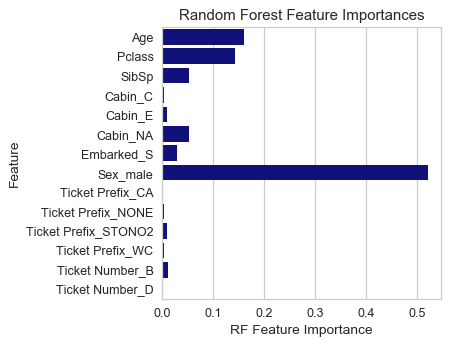

In [102]:
plt.figure(figsize=(4,4), dpi=90)
sns.barplot(y=X_train.columns, x=model_rfc.best_estimator_.feature_importances_, color='darkblue', orient='h')
plt.xlabel('RF Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')

## 4.2 Gradient Boosting
<a id='4.2'></a>

In [103]:
from sklearn.ensemble import GradientBoostingClassifier

In [104]:
param_grid = {'max_depth': [3, 12, 25],
              'subsample': [0.6, 0.8, 1.0],
              'max_features': [None, 'sqrt', 'log2']
             }

In [105]:
model_gb = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, scoring=make_scorer(accuracy_score), n_jobs=-1, verbose=1)

In [106]:
model_gb.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   22.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 12, 25], 'subsample': [0.6, 0.8, 1.0], 'max_features': [None, 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=1)

In [107]:
model_gb.best_params_

{'max_depth': 3, 'max_features': 'log2', 'subsample': 0.6}

In [108]:
model_gb.best_score_

0.8226711560044894

## 4.3 Logistic Regression
<a id='4.3'></a>

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [10**k for k in range(-3,3)],
              'class_weight': [None, 'balanced'],
              'warm_start': [True]
             }

In [111]:
model_logreg = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring=make_scorer(accuracy_score), n_jobs=-1, verbose=1)

In [112]:
model_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    3.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': [None, 'balanced'], 'warm_start': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=1)

In [113]:
model_logreg.best_params_

{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'warm_start': True}

In [114]:
model_logreg.best_score_

0.8047138047138047

## 4.4 Gaussian Naive Bayes
<a id='4.4'></a>

In [115]:
from sklearn.naive_bayes import GaussianNB

In [116]:
model_gnb = GaussianNB()

In [117]:
model_gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [118]:
accuracy_score(y_train, model_gnb.predict(X_train))

0.7631874298540965

## 4.5 Support Vector Classifier
<a id='4.5'></a>

In [119]:
from sklearn.svm import SVC

In [120]:
param_grid = {'C': [10**k for k in range(-3,4)],
              'class_weight': [None, 'balanced'],
              'shrinking': [True, False]
             }

In [121]:
model_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring=make_scorer(accuracy_score), n_jobs=-1, verbose=1)

In [122]:
model_svc.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    4.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'shrinking': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=1)

In [123]:
model_svc.best_params_

{'C': 10, 'class_weight': None, 'shrinking': True}

In [124]:
model_svc.best_score_

0.797979797979798

## 4.6 k-Nearest Neighbors
<a id='4.6'></a>

In [125]:
from sklearn.neighbors import KNeighborsClassifier

In [126]:
param_grid = {'n_neighbors': [1, 2, 4, 8, 16, 32, 64, 128, 256],
              'weights': ['uniform', 'distance'],
              'p': [1, 2, 3, 4, 5]
             }

In [127]:
model_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring=make_scorer(accuracy_score), n_jobs=-1, verbose=1)

In [128]:
model_knn.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 263 out of 270 | elapsed:   14.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   15.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 4, 8, 16, 32, 64, 128, 256], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=1)

In [129]:
model_knn.best_params_

{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}

In [130]:
model_knn.best_score_

0.7890011223344556

# 5 Conclusion
<a id='5'></a>

## 5.1 Results Summary
<a id='5.1'></a>

In [131]:
print('Training Accuracy Scores')
print('Random Forest: ', model_rfc.best_score_)
print('Gradient Boosting: ', model_gb.best_score_)
print('Logistic Regression: ', model_logreg.best_score_)
print('Gaussian Naive Bayes: ', accuracy_score(y_train, model_gnb.predict(X_train)))
print('Support Vector Classifier: ', model_svc.best_score_)
print('k-Nearest Neighbors: ', model_knn.best_score_)

Training Accuracy Scores
Random Forest:  0.8260381593714927
Gradient Boosting:  0.8226711560044894
Logistic Regression:  0.8047138047138047
Gaussian Naive Bayes:  0.7631874298540965
Support Vector Classifier:  0.797979797979798
k-Nearest Neighbors:  0.7890011223344556


## 5.2 Test Set Predictions
<a id='5.2'></a>

In [132]:
y_preds = model_rfc.predict(X_test)

In [133]:
submission = pd.DataFrame({'PassengerId':TestPassengerId, 'Survived':np.uint8(y_preds)})

In [134]:
submission.shape

(418, 2)

In [135]:
submission.sample(5)

,PassengerId,Survived
42,934,0
304,1196,1
2,894,0
79,971,1
71,963,0


In [136]:
submission.to_csv('my_submission.csv', index=False)